In [1]:
import pandas as pd
import json
import fornax
import matplotlib
import networkx as nx

%matplotlib inline

# Performing a Fuzzy Graph Query using Fornax

Im this tutorial we will perform a fuzzy search on the dataset curated during the first tutorial.

You need to run tutorial 1 before doing this tutorial otherwise you will not be able to load any of the data produced.

## Step 1: Load the data from the first tutorial

In [2]:
nodes_df = pd.read_csv('./nodes.csv')
edges_df = pd.read_csv('./edges.csv')

In [3]:
nodes_df.head()

,label,type,uid
0,Jubilee,0,1126900601
1,Silver Surfer,0,440245546
2,Beast,0,1370118169
3,Selene,0,87770955
4,Sabretooth,0,1299099267


In [4]:
edges_df.head()

,end,start
0,272969114,1126900601
1,741356524,440245546
2,1449626873,1370118169
3,609918602,87770955
4,1449626873,1299099267


## Step 2: Create a target graph

We create a target graph by creating a graph handle and loading the nodes and edges into the graph.

We can attach metadata to the nodes using keyword arguments of `GraphHandle.add_nodes`.
`id_src` is a special field which specifies a unique id for each node. By default `id_src` is a continuous range of integers starting at zero.

In [5]:
target_graph = fornax.GraphHandle.create()
target_graph.add_nodes(id_src=nodes_df['uid'], label=nodes_df['label'], type_=nodes_df['type'])
target_graph.add_edges(edges_df['start'], edges_df['end'])

## Step 3: Create a query graph

Creating a query graph is exactly the same as creating a target graph. Because this query graph is small we don't load any values from file.

In [6]:
query_graph = fornax.GraphHandle.create()
query_graph.add_nodes(id_src=[0, 1, 2], label=['hulk', 'lady', 'storm'])
query_graph.add_edges([0, 1], [1, 2])

## Step 4: Create a query

A query needs a set of correspondances between the query and target graph.
They can be anything provided that they are scored between 0 and 1.
Below we create a correspondance between a query node and a target node. If the query node label is a substring of a target node label the correspondance scores 1, otherwise it is zero we don't specify it explicitly.

Just like graph edges, matches are specified using the `src_id` of source and target nodes respectivly.

In [7]:
matches = []
for i in nodes_df[nodes_df['label'].str.contains("(?i)hulk")]['uid']:
    matches.append((0, i, 1))
for i in nodes_df[nodes_df['label'].str.contains('(?i)lady')]['uid']:
    matches.append((1, i, 1))
for i in nodes_df[nodes_df['label'].str.contains('(?i)storm')]['uid']:
    matches.append((2, i, 1))
sources, targets, weights = zip(*matches)

In [8]:
matches[:10]

[(0, 2020667501, 1),
 (0, 2087196931, 1),
 (0, 2142361735, 1),
 (0, 1056123890, 1),
 (0, 970313367, 1),
 (0, 329519748, 1),
 (0, 959673558, 1),
 (0, 560425637, 1),
 (1, 1639515098, 1),
 (1, 995920086, 1)]

A query needs a two graph handles.
Once created we can insert the matches.

In [9]:
query = fornax.QueryHandle.create(query_graph, target_graph)
query.add_matches(sources, targets, weights)

## Exacute the query

The query produces a python dictionary that can be serialised to json.
Each `graph` in the result uses the [node link fromat](https://networkx.github.io/documentation/stable/reference/readwrite/generated/networkx.readwrite.json_graph.node_link_data.html#networkx.readwrite.json_graph.node_link_data) for graphs.

The resulting graphs contain
* The query nodes
* The optimal target nodes matching the query nodes
* Edges between the query nodes
* Edges between the relavent target nodes
* The matches between the query graph and optimum target nodes

In [10]:
# get the n best subgraph matches
results = query.execute(n=1)

/Users/dstaff/anaconda3/envs/fornax/lib/python3.6/site-packages/numpy/core/records.py:513: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.15 because this will return a view instead of a copy -- see release notes for details.
  return obj.view(dtype=(self.dtype.type, obj.dtype))


In [11]:
print(json.dumps(results, indent=4))

{
    "graphs": [
        {
            "is_multigraph": false,
            "cost": 0.024416640711327393,
            "nodes": [
                {
                    "id": 1934515491,
                    "type": "query",
                    "id_src": 0,
                    "label": "hulk"
                },
                {
                    "id": 1325512080,
                    "type": "query",
                    "id_src": 1,
                    "label": "lady"
                },
                {
                    "id": 1876249886,
                    "type": "query",
                    "id_src": 2,
                    "label": "storm"
                },
                {
                    "id": 715503065,
                    "type": "target",
                    "id_src": 37644418,
                    "label": " Susan Storm",
                    "type_": 2
                },
                {
                    "id": 1936330398,
                    "type": "target",
     

# Draw the result using networkx

/Users/dstaff/anaconda3/envs/fornax/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


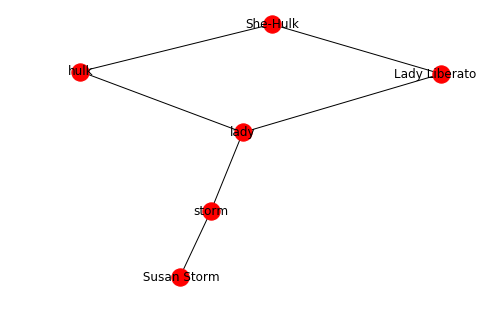

In [12]:
graph = results['graphs'][0]
G = nx.json_graph.node_link_graph(graph)
nx.draw(G, with_labels=True, labels={n['id']:n['label'] for n in graph['nodes']})

## Write the resulting supgraph match using another graph format 

In [15]:
nx.write_gexf(G, 'my_graph.gexf')